## Importing Libraries

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

## Device

In [2]:
# device setup
device = (
    "cuda:0" if torch.cuda.is_available() else # Nvidia GPU
    "mps" if torch.backends.mps.is_available() else # Apple Silicon GPU
    "cpu"
)
print(f"Device = {device}")

Device = mps


## Dataset

In [3]:
# dataset path
dataset_path = 'data/'

# names dataset
names_dataset = dataset_path + 'names.txt'

# read the dataset
with open(names_dataset, 'r') as f:
    names_text = f.readlines()
    
# remove the new line character
names_text = [name.strip() for name in names_text]

In [4]:
# print the first 10 names
names_text[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Number of names: 32033
Number of duplicates: 2539
Minimum Name Length: 2
Maximum Name Length: 15
Average Name Length: 6.122217712983486


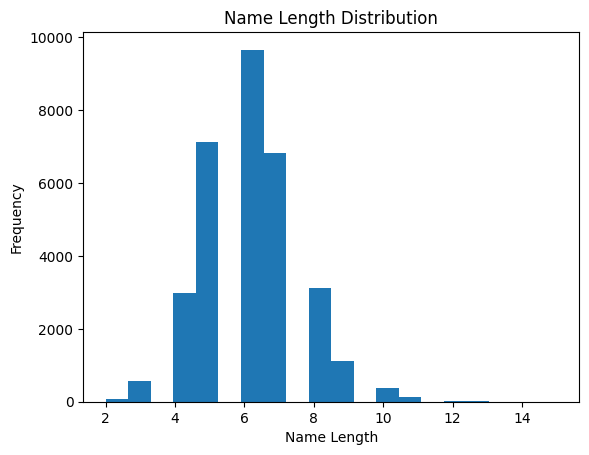

In [5]:
# number of names
print(f'Number of names: {len(names_text)}')

# check for duplicates
print(f'Number of duplicates: {len(names_text) - len(set(names_text))}')

# minimum name length
min_name_length = min([len(name) for name in names_text])
print(f'Minimum Name Length: {min_name_length}')

# maximum name length
max_name_length = max([len(name) for name in names_text])
print(f'Maximum Name Length: {max_name_length}')

# name length statistics
print(f'Average Name Length: {sum([len(name) for name in names_text]) / len(names_text)}')

# name length distribution
plt.hist([len(name) for name in names_text], bins=20)
plt.xlabel('Name Length')
plt.ylabel('Frequency')
plt.title('Name Length Distribution')
plt.show()

In [6]:
# number of unique characters
unique_chars = sorted(list(set(''.join(names_text))))
print(f'Number of Unique Characters: {len(unique_chars)}')

# unique characters
print(unique_chars)

Number of Unique Characters: 26
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


## Tokenization

In [7]:
# add special token
unique_chars = ['.', *unique_chars]

In [8]:
# create character to index mapping
char2idx = {char: idx for idx, char in enumerate(unique_chars)}
print(char2idx)

# create index to character mapping
idx2char = {idx: char for char, idx in char2idx.items()}
print(idx2char)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


## Hyperparameters

In [9]:
# dataset parameters
validation_split = 0.1

# training parameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# model parameters
block_size = 3
vocab_size = len(unique_chars)
embedding_size = 64
hidden_size = 128

## Preprocessing

In [10]:
# add special token to names
names_text = [name + '.' for name in names_text]

In [11]:
# print the first 10 names
names_text[:10]

['emma.',
 'olivia.',
 'ava.',
 'isabella.',
 'sophia.',
 'charlotte.',
 'mia.',
 'amelia.',
 'harper.',
 'evelyn.']

In [12]:
# custom dataset: 3 characters -> 1 character
class NamesDataset(Dataset):
    def __init__(self, block_size):
        self.block_size = block_size
        self.data = self.create_sequence()
        
    def create_sequence(self):
        sequence = []
        for name in names_text:
            name = '.' * self.block_size + name
            for i in range(len(name) - self.block_size):
                context = name[i:i+self.block_size]
                target = name[i+self.block_size]
                sequence_idx = [char2idx[char] for char in context]
                target_idx = char2idx[target]
                sequence.append((sequence_idx, target_idx))
        return sequence
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        context, target = self.data[idx]
        context_tensor = torch.tensor(context, dtype=torch.long)
        target_tensor = torch.tensor(target, dtype=torch.long)
        return context_tensor, target_tensor
        
# create dataset
names_dataset = NamesDataset(block_size)

# validation split
val_size = int(validation_split * len(names_dataset))
train_size = len(names_dataset) - val_size
train_dataset, val_dataset = random_split(names_dataset, [train_size, val_size])

# create dataloader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [13]:
# check the dataset
X, Y = names_dataset[0]
print(X.shape, Y.shape)

# check the dataloader
X, Y = next(iter(train_loader))
print(X.shape, Y.shape)

torch.Size([3]) torch.Size([])
torch.Size([64, 3]) torch.Size([64])


## Model

In [18]:
class Embedding:
    def __init__(self, vocab_size, embedding_size):
        self.embedding = torch.randn(vocab_size, embedding_size)
        
    def forward(self, x):
        return self.embedding[x]
    
    def backward(self, dy):
        dW = torch.zeros_like(self.embedding)
        dW[self.x] = dy
        return dW

In [14]:
class Linear:
    def __init__(self, in_features, out_features):
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.randn(in_features, out_features) * (5/3) / ((in_features + out_features) ** 0.5)
        self.bias = torch.randn(out_features) * 0.01
        
    def forward(self, x):
        self.x = x
        return x @ self.weight + self.bias
    
    def backward(self, dy):
        self.dW = self.x.t() @ dy
        self.db = dy.sum(dim=0)
        dx = dy @ self.weight.t()
        return dx
    
    def update(self, lr):
        self.weight -= lr * self.dW
        self.bias -= lr * self.db

In [15]:
class Tanh:
    def forward(self, x):
        self.x = x
        return torch.tanh(x)
    
    def backward(self, dy):
        return dy * (1 - self.x ** 2)

In [16]:
class Softmax:
    def forward(self, x):
        exps = torch.exp(x)
        return exps / exps.sum(dim=-1, keepdim=True)
    
    def backward(self, dy):
        return dy

In [17]:
class BatchNorm1d:
    def __init__(self, num_features):
        self.num_features = num_features
        self.gamma = torch.ones(num_features)
        self.beta = torch.zeros(num_features)
        self.eps = 1e-5
        self.moving_mean = torch.zeros(num_features)
        self.moving_var = torch.ones(num_features)
        
    def forward(self, x, training=True):
        if training:
            mean = x.mean(dim=0)
            var = x.var(dim=0)
            x_hat = (x - mean) / torch.sqrt(var + self.eps)
            self.moving_mean = 0.9 * self.moving_mean + 0.1 * mean
            self.moving_var = 0.9 * self.moving_var + 0.1 * var
        else:
            x_hat = (x - self.moving_mean) / torch.sqrt(self.moving_var + self.eps)
        return self.gamma * x_hat + self.beta
    
    def backward(self, dy):
        m = dy.size(0)
        dx_hat = dy * self.gamma
        dgamma = (dy * self.x).sum(dim=0)
        dbeta = dy.sum(dim=0)
        dx = (m * dx_hat - dx_hat.sum(dim=0) - self.x * (dx_hat * self.x).sum(dim=0)) / (m * torch.sqrt(self.moving_var + self.eps))
        return dx, dgamma, dbeta

In [28]:
"""
class MLP(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(MLP, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_size)
        self.fc1 = nn.Linear(embedding_size * block_size, hidden_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, x):
        x = self.embedding(x)
        x = x.view(x.size(0), -1)
        x = F.tanh(self.fc1(x))
        x = self.batch_norm(x)
        x = self.fc2(x)
        return x
"""
class MLP():
    def __init__(self, vocab_size, embedding_size, hidden_size):
        self.embedding = Embedding(vocab_size, embedding_size)
        self.fc1 = Linear(embedding_size * block_size, hidden_size)
        self.tanh = Tanh()
        self.fc2 = Linear(hidden_size, vocab_size)
        self.batch_norm = BatchNorm1d(hidden_size)
        self.softmax = Softmax()
        
    def forward(self, x):
        x = self.embedding.forward(x)
        self.x1 = self.fc1.forward(x)
        x = self.tanh.forward(self.x1)
        x = self.batch_norm.forward(x)
        self.x2 = self.fc2.forward(x)
        return self.softmax.forward(self.x2)
    
    def backward(self, dy):
        dy = self.softmax.backward(dy)
        dy = self.fc2.backward(dy)
        dy = self.batch_norm.backward(dy)
        dy = self.tanh.backward(dy)
        dy = self.fc1.backward(dy)
        return dy
    
    def update(self, lr):
        self.fc1.update(lr)
        self.fc2.update(lr)
        self.batch_norm.gamma -= lr * self.batch_norm.dgamma
        self.batch_norm.beta -= lr * self.batch_norm.dbeta
        
    def train(self, X, Y, lr):
        x = self.forward(X)
        loss = F.nll_loss(x, Y)
        dy = x.clone()
        dy[range(X.size(0)), Y] -= 1
        dy /= X.size(0)
        dy = self.backward(dy)
        self.update(lr)
        return loss
    
    def eval(self, X):
        return self.forward(X)
    
    def save(self, path):
        torch.save({
            'embedding': self.embedding.embedding,
            'fc1_weight': self.fc1.weight,
            'fc1_bias': self.fc1.bias,
            'fc2_weight': self.fc2.weight,
            'fc2_bias': self.fc2.bias,
            'gamma': self.batch_norm.gamma,
            'beta': self.batch_norm.beta,
            'moving_mean': self.batch_norm.moving_mean,
            'moving_var': self.batch_norm.moving_var
        }, path)
        
    def load(self, path):
        checkpoint = torch.load(path)
        self.embedding.embedding = checkpoint['embedding']
        self.fc1.weight = checkpoint['fc1_weight']
        self.fc1.bias = checkpoint['fc1_bias']
        self.fc2.weight = checkpoint['fc2_weight']
        self.fc2.bias = checkpoint['fc2_bias']
        self.batch_norm.gamma = checkpoint['gamma']
        self.batch_norm.beta = checkpoint['beta']
        self.batch_norm.moving_mean = checkpoint['moving_mean']
        self.batch_norm.moving_var = checkpoint['moving_var']
        
    def parameters(self):
        return [
            self.embedding.embedding,
            self.fc1.weight,
            self.fc1.bias,
            self.fc2.weight,
            self.fc2.bias,
            self.batch_norm.gamma,
            self.batch_norm.beta,
            self.batch_norm.moving_mean,
            self.batch_norm.moving_var
        ]
        
    def to(self, device):
        self.embedding.embedding = self.embedding.embedding.to(device)
        self.fc1.weight = self.fc1.weight.to(device)
        self.fc1.bias = self.fc1.bias.to(device)
        self.fc2.weight = self.fc2.weight.to(device)
        self.fc2.bias = self.fc2.bias.to(device)
        self.batch_norm.gamma = self.batch_norm.gamma.to(device)
        self.batch_norm.beta = self.batch_norm.beta.to(device)
        self.batch_norm.moving_mean = self.batch_norm.moving_mean.to(device)
        self.batch_norm.moving_var = self.batch_norm.moving_var.to(device)
        return self
        
    def __call__(self, X):
        return self.forward(X)
    
model = MLP(vocab_size, embedding_size, hidden_size).to(device)
print(f"Number of parameters: {sum(p.numel() for p in model.parameters())}")

# check the model
X, Y = next(iter(train_loader))
print(X.shape, Y.shape)
model(X).shape

Number of parameters: 30427
torch.Size([64, 3]) torch.Size([64])


RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x64 and 192x128)

## Neuron Activation

## Training

In [ ]:
model.train

## Inference